In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "BBR-BPC"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn025821,MFAVDLPFELNVLGHNCDPLGMDGAQVGVLKQTHQLFLTVELQMDD...,357,1
1,Achn049331,MRVQTIQFTPITSGEAHRFAAILLKHASTGLGLLVFEAYFCSVSAF...,388,1
2,Achn053261,MAERDSAIREKNMALDERRRAFAERDMAMLQRDAAIAERNSAVEER...,288,1
3,Achn067521,MVEVICHGSYFDFIRCTSRWFGSLNSVTSCSKLFEVSESCESREIL...,323,1
4,Achn075701,MAERDAAIRERNAALDERRRAFAERDMAMLQRDMGIAERNTAIEER...,283,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
130,0.003012,0.003012,0.003012,0.003012,0.003012,0.018072,0.003012,0.003012,0.003012,0.000000,...,0.003012,0.003012,0.0,0.003012,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1443,0.004329,0.000000,0.000000,0.004329,0.000000,0.008658,0.012987,0.008658,0.012987,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1185,0.014663,0.000000,0.005865,0.011730,0.005865,0.000000,0.005865,0.017595,0.014663,0.002933,...,0.000000,0.002933,0.0,0.005865,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1118,0.003623,0.003623,0.000000,0.000000,0.007246,0.007246,0.003623,0.000000,0.003623,0.003623,...,0.003623,0.007246,0.0,0.003623,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1902,0.006565,0.000000,0.000000,0.000000,0.000000,0.006565,0.000000,0.002188,0.002188,0.006565,...,0.002188,0.000000,0.0,0.000000,0.004376,0.002188,0.006565,0.002188,0.002188,0.0


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (1989, 439)
X_test: (498, 439)
y_train: (1989,)
y_test: (498,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         112,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,905 (609.00 KB)

 Trainable params: 155,905 (609.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 15s 635ms/step - accuracy: 0.4688 - loss: 0.6933

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6931 - loss: 0.6813 - val_accuracy: 0.9824 - val_loss: 0.5287


Epoch 2/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9375 - loss: 0.5344

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9802 - loss: 0.3965 - val_accuracy: 0.9874 - val_loss: 0.0531


Epoch 3/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0552

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9910 - loss: 0.0370 - val_accuracy: 0.9874 - val_loss: 0.0378


Epoch 4/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0043

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9933 - loss: 0.0187 - val_accuracy: 0.9849 - val_loss: 0.0592


Epoch 5/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.0729

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9931 - loss: 0.0185 - val_accuracy: 0.9925 - val_loss: 0.0367


Epoch 6/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0195

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0065 - val_accuracy: 0.9899 - val_loss: 0.0395


Epoch 7/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 7.9374e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0037 - val_accuracy: 0.9849 - val_loss: 0.0487


Epoch 8/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 7.2841e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - loss: 0.0055 - val_accuracy: 0.9925 - val_loss: 0.0464


Epoch 9/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0011

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0011 - val_accuracy: 0.9899 - val_loss: 0.0415


Epoch 10/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 5.5208e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9899 - val_loss: 0.0516


Epoch 11/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 4.0050e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 8.4488e-04 - val_accuracy: 0.9925 - val_loss: 0.0471


Epoch 12/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 1.8434e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.7545e-04 - val_accuracy: 0.9925 - val_loss: 0.0514


Epoch 13/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0013

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.6793e-04 - val_accuracy: 0.9925 - val_loss: 0.0523


Epoch 14/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 1.2419e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.7614e-04 - val_accuracy: 0.9925 - val_loss: 0.0497


Epoch 15/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 1.9164e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.2154e-04 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.2419e-04 - val_accuracy: 0.9925 - val_loss: 0.0543



[Train Accuracy: 100.00% - Test Accuracy: 100.00%]


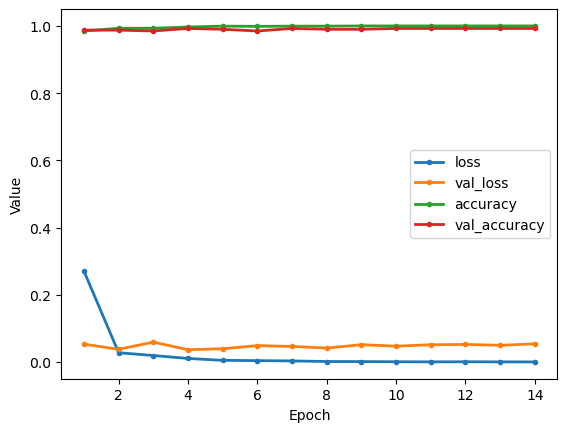

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
130,0.0,0.0,0.000000,0.0,0.0,0.0,0.003021,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1443,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1185,0.0,0.0,0.002941,0.0,0.0,0.0,0.000000,0.005882,0.0,0.002941,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1118,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1902,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.002193,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (1989, 8480)
X_test: (498, 8480)
y_train: (1989,)
y_test: (498,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,171,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,214,401 (8.45 MB)

 Trainable params: 2,214,401 (8.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 15s 647ms/step - accuracy: 0.5000 - loss: 0.6932

 7/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5346 - loss: 0.6919   

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6095 - loss: 0.6881

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6793 - loss: 0.6798

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6990 - loss: 0.6753 - val_accuracy: 0.9899 - val_loss: 0.4685


Epoch 2/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9844 - loss: 0.4789

 9/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9909 - loss: 0.4158 

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9926 - loss: 0.3516

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9935 - loss: 0.3050 - val_accuracy: 0.9925 - val_loss: 0.0209


Epoch 3/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9844 - loss: 0.0390

 9/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9951 - loss: 0.0204 

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9965 - loss: 0.0163

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9970 - loss: 0.0142 - val_accuracy: 0.9975 - val_loss: 0.0084


Epoch 4/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0020

 9/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0021 

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0019

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0019

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 0.0019 - val_accuracy: 0.9975 - val_loss: 0.0090


Epoch 5/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0012

 9/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0012 

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9925 - val_loss: 0.0186


Epoch 6/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.0747e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.9057e-04 

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.5571e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.7269e-04 - val_accuracy: 0.9975 - val_loss: 0.0106


Epoch 7/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.8998e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.0794e-04 

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.0091e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.6302e-04 - val_accuracy: 0.9925 - val_loss: 0.0108


Epoch 8/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.9134e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8557e-04 

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9680e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9121e-04 - val_accuracy: 0.9925 - val_loss: 0.0181


Epoch 9/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0014

 9/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.6822e-04

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.4340e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9234e-04 - val_accuracy: 0.9925 - val_loss: 0.0133


Epoch 10/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.6680e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6294e-04 

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6821e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7857e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.8082e-04 - val_accuracy: 0.9925 - val_loss: 0.0147


Epoch 11/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.6715e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4100e-04 

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3053e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2860e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2840e-04 - val_accuracy: 0.9925 - val_loss: 0.0206


Epoch 12/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 5.3625e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5878e-04 

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2107e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0077e-04 - val_accuracy: 0.9925 - val_loss: 0.0263


Epoch 13/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 7.3006e-05

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.4327e-05 

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.2580e-05

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.4192e-05 - val_accuracy: 0.9925 - val_loss: 0.0228



[Train Accuracy: 100.00% - Test Accuracy: 99.80%]


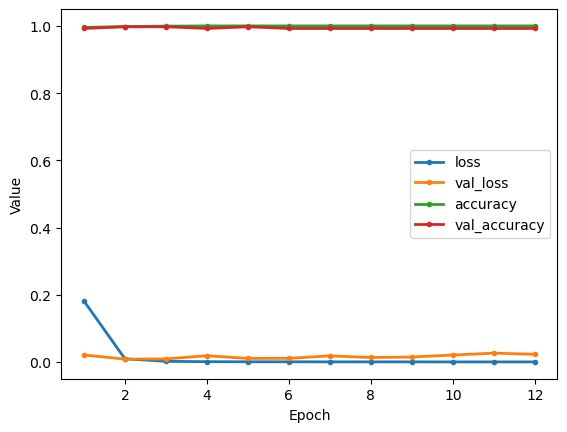

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      30,360,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,401,281 (115.97 MB)

 Trainable params: 30,401,281 (115.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 20s 851ms/step - accuracy: 0.6094 - loss: 0.6931

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5781 - loss: 0.6931  

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5660 - loss: 0.6930

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5602 - loss: 0.6928

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5519 - loss: 0.6927

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5476 - loss: 0.6925

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5443 - loss: 0.6922

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5417 - loss: 0.6920

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5398 - loss: 0.6917

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5391 - loss: 0.6914

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5411 - loss: 0.6910

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5456 - loss: 0.6906

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5514 - loss: 0.6902

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5581 - loss: 0.6897

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5654 - loss: 0.6891

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5731 - loss: 0.6885

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5810 - loss: 0.6879

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5888 - loss: 0.6871

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5966 - loss: 0.6864

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6043 - loss: 0.6855

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6118 - loss: 0.6846

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6191 - loss: 0.6836

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6262 - loss: 0.6826

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6331 - loss: 0.6814

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6397 - loss: 0.6802

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.6458 - loss: 0.6791 - val_accuracy: 1.0000 - val_loss: 0.5219


Epoch 2/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.5311

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 1.0000 - loss: 0.5203 

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 0.5139

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.5082

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9994 - loss: 0.5015

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9990 - loss: 0.4953

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9989 - loss: 0.4890

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9988 - loss: 0.4830

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9987 - loss: 0.4772

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9987 - loss: 0.4715

11/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9987 - loss: 0.4656

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9985 - loss: 0.4599

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9983 - loss: 0.4542

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9982 - loss: 0.4485

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9981 - loss: 0.4427

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9980 - loss: 0.4369

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9980 - loss: 0.4312

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9979 - loss: 0.4255

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9979 - loss: 0.4197

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9979 - loss: 0.4141

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9979 - loss: 0.4086

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9978 - loss: 0.4031

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9978 - loss: 0.3977

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9977 - loss: 0.3925

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9976 - loss: 0.3873

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.9976 - loss: 0.3825 - val_accuracy: 1.0000 - val_loss: 0.0483


Epoch 3/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 0.0559

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 1.0000 - loss: 0.0510 

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9983 - loss: 0.0515

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9977 - loss: 0.0504

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9976 - loss: 0.0486

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9971 - loss: 0.0476

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9969 - loss: 0.0464

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9968 - loss: 0.0451

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9967 - loss: 0.0439

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9968 - loss: 0.0427

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9968 - loss: 0.0416

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9968 - loss: 0.0405

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9969 - loss: 0.0395

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9970 - loss: 0.0386

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9970 - loss: 0.0377

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9971 - loss: 0.0368

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9972 - loss: 0.0360

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9972 - loss: 0.0352

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9973 - loss: 0.0345

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9973 - loss: 0.0338

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9974 - loss: 0.0331

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9974 - loss: 0.0324

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9975 - loss: 0.0318

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9975 - loss: 0.0313

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9976 - loss: 0.0307

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9976 - loss: 0.0302 - val_accuracy: 1.0000 - val_loss: 0.0055


Epoch 4/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 0.0026

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 1.0000 - loss: 0.0028 

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 1.0000 - loss: 0.0028

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 0.0028

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0028

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 0.0028

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 0.0028

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0028

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0028

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0028

11/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0028

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0028

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0028

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0028

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0028

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0028

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0028

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0028

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0028

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0027

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0027

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0027

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0027

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0027

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0026

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 0.0034


Epoch 5/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 0.0010

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 1.0000 - loss: 0.0010 

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 0.0010

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0010

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 9.9953e-04

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 9.9684e-04

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 9.8982e-04

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 9.8563e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 9.7908e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 9.7499e-04

11/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 9.6876e-04

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 9.6519e-04

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 9.6290e-04

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9999 - loss: 0.0011    

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9999 - loss: 0.0012

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9998 - loss: 0.0013

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9998 - loss: 0.0014

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9997 - loss: 0.0014

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9997 - loss: 0.0015

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9997 - loss: 0.0015

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9997 - loss: 0.0016

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9996 - loss: 0.0016

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9996 - loss: 0.0016

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9996 - loss: 0.0016

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9996 - loss: 0.0017

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9996 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0024


Epoch 6/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 0.0015

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 1.0000 - loss: 0.0016 

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 1.0000 - loss: 0.0015

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 0.0015

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0015

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 0.0014

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 0.0014

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 0.0014

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0013

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0013

11/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0013

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0013

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0013

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0012

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0012

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0012

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0012

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0012

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0012

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0012

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0012

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0011

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0011

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0011

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0011

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 0.0026


Epoch 7/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 1.0000 - loss: 4.6156e-04

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 6.9844e-04

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 7.5455e-04

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 7.6172e-04

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 7.5362e-04

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 7.4083e-04

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 7.2558e-04

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 7.1604e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 7.1048e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 7.0499e-04

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 6.9885e-04

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 6.9254e-04

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 6.8602e-04

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 6.7858e-04

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 6.7166e-04

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 6.6670e-04

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 6.6112e-04

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 6.5568e-04

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 6.5004e-04

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 6.4471e-04

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 6.3944e-04

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 6.3453e-04

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 6.3033e-04

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 6.2607e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 6.2255e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 1.0000 - loss: 6.1930e-04 - val_accuracy: 1.0000 - val_loss: 0.0024


Epoch 8/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 3.0523e-04

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 1.0000 - loss: 3.1019e-04 

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 3.2767e-04

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 3.3577e-04

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 3.3923e-04

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.3969e-04

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 3.3842e-04

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.4055e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.4177e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 3.4128e-04

11/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 3.4110e-04

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 3.4130e-04

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 3.4169e-04

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 3.4216e-04

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 3.4244e-04

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 3.4258e-04

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 3.4361e-04

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 3.4489e-04

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 3.4612e-04

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 3.4706e-04

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 3.4832e-04

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 3.4914e-04

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 3.4974e-04

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 3.5036e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 3.5080e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 1.0000 - loss: 3.5120e-04 - val_accuracy: 1.0000 - val_loss: 0.0020


Epoch 9/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 1.7832e-04

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 1.0000 - loss: 2.2519e-04 

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 2.6027e-04

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 2.7483e-04

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 2.8475e-04

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 2.9265e-04

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 2.9700e-04

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.0545e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 3.1191e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 3.1547e-04

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 3.1810e-04

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 3.1923e-04

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 3.2361e-04

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 3.2781e-04

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 3.3088e-04

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 3.3284e-04

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 3.3413e-04

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 3.3573e-04

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 3.3677e-04

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 3.3734e-04

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 3.3765e-04

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 3.3780e-04

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 3.3804e-04

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 3.3854e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 3.3889e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 1.0000 - loss: 3.3921e-04 - val_accuracy: 1.0000 - val_loss: 0.0016


Epoch 10/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.6200e-04

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 1.0000 - loss: 1.8768e-04 

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 2.0481e-04

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 2.1240e-04

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 2.1240e-04

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 2.1350e-04

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.2358e-04

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 2.2932e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 2.3253e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 2.3416e-04

11/25 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 2.3546e-04

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 2.4380e-04

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 2.4996e-04

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 2.5455e-04

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 2.5851e-04

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 2.6134e-04

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.6374e-04

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.6554e-04

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.6717e-04

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.6842e-04

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.6967e-04

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.7087e-04

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.7189e-04

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.7278e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.7341e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 1.0000 - loss: 2.7399e-04 - val_accuracy: 1.0000 - val_loss: 0.0012


Epoch 11/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 1.7554e-04

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 1.0000 - loss: 1.8136e-04 

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 1.8194e-04

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 1.8974e-04

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 1.9103e-04

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.9536e-04

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.9776e-04

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.9754e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.9726e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.9691e-04

11/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.9579e-04

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.9445e-04

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.9304e-04

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.9145e-04

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.9177e-04

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.9199e-04

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.9214e-04

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.9207e-04

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.9250e-04

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.9262e-04

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.9260e-04

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.9251e-04

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.9232e-04

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.9195e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.9170e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 1.0000 - loss: 1.9147e-04 - val_accuracy: 1.0000 - val_loss: 0.0014



[Train Accuracy: 100.00% - Test Accuracy: 99.60%]


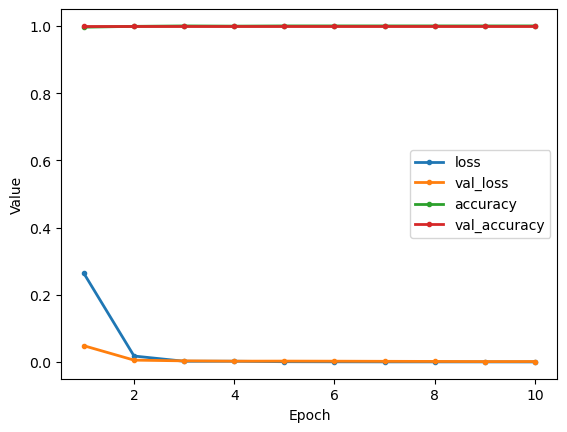

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [26]:
report.save()

Report saved as Output/Reports/BBR-BPC/report_GKA8BJSR.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################